<a href="https://colab.research.google.com/github/Anvarka/Crime_prediction/blob/main/%D0%9A%D0%BE%D0%BF%D0%B8%D1%8F_%D0%B1%D0%BB%D0%BE%D0%BA%D0%BD%D0%BE%D1%82%D0%B0_%22Chicago_crime_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import random
from tqdm import tqdm
import pandas as pd
from datetime import datetime
! pip install wandb
import wandb
import matplotlib.pyplot as plt
import seaborn as sn
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

In [54]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [55]:
data = pd.read_csv('/content/drive/MyDrive/DL/data/Crimes_-_2001_to_Present.csv')
data

,ID,Case Number,Date,Block,IUCR,Primary Type,Description,Location Description,Arrest,Domestic,Beat,District,Ward,Community Area,FBI Code,X Coordinate,Y Coordinate,Year,Updated On,Latitude,Longitude,Location
0,10224738,HY411648,09/05/2015 01:30:00 PM,043XX S WOOD ST,0486,BATTERY,DOMESTIC BATTERY SIMPLE,RESIDENCE,False,True,924,9.0,12.0,61.0,08B,1165074.0,1875917.0,2015,02/10/2018 03:50:01 PM,41.815117,-87.670000,"(41.815117282, -87.669999562)"
1,10224739,HY411615,09/04/2015 11:30:00 AM,008XX N CENTRAL AVE,0870,THEFT,POCKET-PICKING,CTA BUS,False,False,1511,15.0,29.0,25.0,06,1138875.0,1904869.0,2015,02/10/2018 03:50:01 PM,41.895080,-87.765400,"(41.895080471, -87.765400451)"
2,11646166,JC213529,09/01/2018 12:01:00 AM,082XX S INGLESIDE AVE,0810,THEFT,OVER $500,RESIDENCE,False,True,631,6.0,8.0,44.0,06,NaN,NaN,2018,04/06/2019 04:04:43 PM,NaN,NaN,NaN
3,10224740,HY411595,09/05/2015 12:45:00 PM,035XX W BARRY AVE,2023,NARCOTICS,POSS: HEROIN(BRN/TAN),SIDEWALK,True,False,1412,14.0,35.0,21.0,18,1152037.0,1920384.0,2015,02/10/2018 03:50:01 PM,41.937406,-87.716650,"(41.937405765, -87.716649687)"
4,10224741,HY411610,09/05/2015 01:00:00 PM,0000X N LARAMIE AVE,0560,ASSAULT,SIMPLE,APARTMENT,False,True,1522,15.0,28.0,25.0,08A,1141706.0,1900086.0,2015,02/10/2018 03:50:01 PM,41.881903,-87.755121,"(41.881903443, -87.755121152)"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7470112,12586249,JF105409,01/06/2022 10:09:00 PM,119XX S EMERALD AVE,143A,WEAPONS VIOLATION,UNLAWFUL POSSESSION - HANDGUN,STREET,True,False,524,5.0,34.0,53.0,15,1173472.0,1825641.0,2022,01/13/2022 03:49:31 PM,41.676971,-87.640679,"(41.676971442, -87.640679024)"
7470113,12590639,JF110748,01/06/2022 12:00:00 PM,017XX W PRYOR AVE,0560,ASSAULT,SIMPLE,SCHOOL - PUBLIC GROUNDS,False,True,2212,22.0,19.0,75.0,08A,NaN,NaN,2022,01/13/2022 03:49:31 PM,NaN,NaN,NaN
7470114,12587463,JF106988,01/06/2022 08:00:00 AM,023XX N CALIFORNIA AVE,0910,MOTOR VEHICLE THEFT,AUTOMOBILE,STREET,False,False,1431,14.0,1.0,22.0,07,1157310.0,1915626.0,2022,01/13/2022 03:49:31 PM,41.924244,-87.697400,"(41.924243748, -87.697400159)"
7470115,12586262,JF105402,01/06/2022 12:00:00 PM,008XX W IRVING PARK RD,0810,THEFT,OVER $500,HOSPITAL BUILDING / GROUNDS,False,False,1915,19.0,46.0,3.0,06,1169789.0,1926761.0,2022,01/13/2022 03:49:31 PM,41.954536,-87.651222,"(41.954535555, -87.651221802)"


In [56]:
data = data[["Date", "Primary Type", "District"]]
data['Date'] = data['Date'].apply(lambda x: datetime.strptime(x, '%m/%d/%Y %H:%M:%S %p').date())
data

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Date,Primary Type,District
0,2015-09-05,BATTERY,9.0
1,2015-09-04,THEFT,15.0
2,2018-09-01,THEFT,6.0
3,2015-09-05,NARCOTICS,14.0
4,2015-09-05,ASSAULT,15.0
...,...,...,...
7470112,2022-01-06,WEAPONS VIOLATION,5.0
7470113,2022-01-06,ASSAULT,22.0
7470114,2022-01-06,MOTOR VEHICLE THEFT,14.0
7470115,2022-01-06,THEFT,19.0


In [57]:
data = data.dropna()
data = data.sort_values('Date').reset_index(drop=True)
data.head(100)

,Date,Primary Type,District
0,2001-01-01,ROBBERY,25.0
1,2001-01-01,CRIMINAL DAMAGE,6.0
2,2001-01-01,OTHER OFFENSE,3.0
3,2001-01-01,ASSAULT,24.0
4,2001-01-01,CRIMINAL DAMAGE,6.0
...,...,...,...
95,2001-01-01,THEFT,14.0
96,2001-01-01,THEFT,24.0
97,2001-01-01,BATTERY,2.0
98,2001-01-01,CRIMINAL DAMAGE,17.0


In [62]:
data = data[(data["District"] != 21.0) & (data["District"] != 31.0)]
data.groupby("District").count()

,Date,Primary Type
District,,
1.0,297653,297653
2.0,352809,352809
3.0,378980,378980
4.0,423623,423623
5.0,332190,332190
6.0,435766,435766
7.0,436837,436837
8.0,503476,503476
9.0,366774,366774


In [ ]:
data

In [70]:
df = pd.DataFrame()
for _name in np.unique(data["District"]):
    df = pd.concat([df, data[data["District"] == _name].sample(n=100_000, random_state=42)])

In [73]:
df.groupby("Primary Type").count()

,Date,District
Primary Type,,
ARSON,3654,3654
ASSAULT,138734,138734
BATTERY,396949,396949
BURGLARY,121548,121548
CONCEALED CARRY LICENSE VIOLATION,248,248
CRIM SEXUAL ASSAULT,8172,8172
CRIMINAL DAMAGE,251999,251999
CRIMINAL SEXUAL ASSAULT,1330,1330
CRIMINAL TRESPASS,63335,63335


In [41]:
data = df.sort_values('Date').reset_index(drop=True)

In [42]:
mapping = {v: k for k, v in enumerate(data['Primary Type'].unique())}
data['UCRCrime_mapping'] = data['Primary Type'].map(mapping)
data

,Date,Primary Type,District,UCRCrime_mapping
0,2001-01-01,THEFT,9.0,0
1,2001-01-01,SEX OFFENSE,14.0,1
2,2001-01-01,OTHER OFFENSE,24.0,2
3,2001-01-01,OFFENSE INVOLVING CHILDREN,8.0,3
4,2001-01-01,BATTERY,1.0,4
...,...,...,...,...
2199995,2022-01-06,THEFT,17.0,0
2199996,2022-01-06,BATTERY,22.0,4
2199997,2022-01-06,THEFT,18.0,0
2199998,2022-01-06,MOTOR VEHICLE THEFT,1.0,7


In [131]:
data.groupby(by='District').count()

,Date,Primary Type,UCRCrime_mapping
District,,,
1.0,100000,100000,100000
2.0,100000,100000,100000
3.0,100000,100000,100000
4.0,100000,100000,100000
5.0,100000,100000,100000
6.0,100000,100000,100000
7.0,100000,100000,100000
8.0,100000,100000,100000
9.0,100000,100000,100000


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


KeyboardInterrupt: ignored

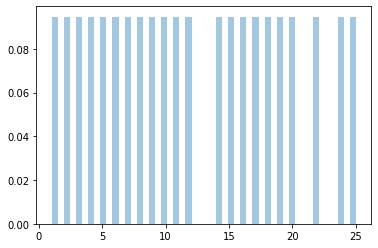

In [78]:
sn.distplot(data['District'])

In [82]:
np.unique(data["District"].apply(int))

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 14, 15, 16, 17, 18,
       19, 20, 22, 24, 25])

In [43]:
y1 = F.one_hot(torch.tensor(data['District'].values, dtype=int))
y2 = F.one_hot(torch.tensor(data['UCRCrime_mapping'].values, dtype=int))

In [44]:
y = torch.hstack([y1, y2])
print("y.shape", y.shape)
print("y1.shape", y1.shape)
print("y2.shape", y2.shape)
SEQ_SIZE = 32
init_ = random.randint(0, len(data) - SEQ_SIZE - 1)
y[init_:init_+SEQ_SIZE].shape

y.shape torch.Size([2200000, 61])
y1.shape torch.Size([2200000, 26])
y2.shape torch.Size([2200000, 35])


torch.Size([32, 61])

In [45]:
COUNT_ACTUAL_NEIGHBORHOOD = len(np.unique(data["District"]))
COUNT_UCRCRIME = len(np.unique(data["Primary Type"]))
COUNT_NEIGHBORHOOD = y1.shape[-1]

In [46]:
class EmbeddingNet(nn.Module):
    def __init__(self):
        super(EmbeddingNet, self).__init__()
        self.INPUT_DIM = COUNT_NEIGHBORHOOD + COUNT_UCRCRIME
        self.LATENT_DIM = 64

        self.lstm = nn.LSTM(self.INPUT_DIM, self.LATENT_DIM, 1, bidirectional=False)
        self.fc1 = nn.Sequential(nn.Linear(self.LATENT_DIM, COUNT_NEIGHBORHOOD), nn.Softmax(dim=2))
        self.fc2 = nn.Sequential(nn.Linear(self.LATENT_DIM, COUNT_UCRCRIME), nn.Softmax(dim=2))

    def forward(self, x):
        lstm_output = self.lstm(x)[0]
        return (self.fc1(lstm_output), self.fc2(lstm_output))

In [47]:
from torch.utils.data import Dataset
SEQ_SIZE = 128
BATCH_SIZE = 1024
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

class DatasetCrime(Dataset):
    def __init__(self, y, seq_size, is_train=True):
        self.y = y
        split_id = int(len(self.y) * 0.9)
        self.train = y[: split_id]
        self.test = y[split_id: ]
        self.seq_size = seq_size
        self.is_train = is_train

    def __len__(self):
        if self.is_train:
            return len(self.train) // self.seq_size
        return len(self.test) // self.seq_size

    def __getitem__(self, idx):
        if self.is_train:
            return self.train[idx * self.seq_size: idx * self.seq_size + self.seq_size + 1]
        return self.test[idx * self.seq_size: idx * self.seq_size + self.seq_size + 1]

from torch.utils.data import DataLoader
train_data = DatasetCrime(y, SEQ_SIZE)
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

test_data = DatasetCrime(y, SEQ_SIZE, is_train=False)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE)

cuda


In [48]:
wandb.init()

COUNT_EPOCHS = 30

loss = nn.BCELoss()
model = EmbeddingNet().to(DEVICE)
optimizer = torch.optim.Adam(model.parameters())

for epoch in range(COUNT_EPOCHS):
    print(f"--epoch: {epoch} --")
    for i, batch in enumerate(train_dataloader):
        y_batch = batch[:, 0:SEQ_SIZE, :]

        optimizer.zero_grad()

        prob1, prob2 = model(y_batch.float().to(DEVICE))
        
        y1_batch = batch[:, 1:SEQ_SIZE + 1, :COUNT_NEIGHBORHOOD]
        y2_batch = batch[:, 1:SEQ_SIZE + 1, COUNT_NEIGHBORHOOD:]

        # y1_batch = batch[:, SEQ_SIZE:2*SEQ_SIZE, :COUNT_NEIGHBORHOOD]
        # y2_batch = batch[:, SEQ_SIZE:2*SEQ_SIZE, COUNT_NEIGHBORHOOD:]

        loss1 = loss(prob1, y1_batch.float().to(DEVICE))
        loss2 = loss(prob2, y2_batch.float().to(DEVICE))
        loss_ = loss1 + loss2

        loss_.backward()
        optimizer.step()
    
    log_dict = {
        "train_loss": loss_.to("cpu"),
        "loss1": loss1.to("cpu"),
        "loss2": loss2.to("cpu"), 
        "i_mean_grad": model.lstm.weight_ih_l0.grad.mean(),
        "h_mean_grad": model.lstm.weight_hh_l0.grad.mean(),
        "i_std_grad": model.lstm.weight_ih_l0.grad.std(),
        "h_std_grad": model.lstm.weight_hh_l0.grad.std(),
    }
    wandb.log(log_dict)

    if epoch % 100 == 0:
        torch.save(model.state_dict(), f"/content/drive/MyDrive/DL/chicago_models/model_{epoch}_loss_{float(loss_)}.pth")
    # print(loss_)

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


--epoch: 0 --
--epoch: 1 --
--epoch: 2 --
--epoch: 3 --
--epoch: 4 --
--epoch: 5 --
--epoch: 6 --
--epoch: 7 --
--epoch: 8 --
--epoch: 9 --
--epoch: 10 --
--epoch: 11 --
--epoch: 12 --
--epoch: 13 --
--epoch: 14 --
--epoch: 15 --
--epoch: 16 --
--epoch: 17 --
--epoch: 18 --
--epoch: 19 --
--epoch: 20 --
--epoch: 21 --
--epoch: 22 --
--epoch: 23 --
--epoch: 24 --
--epoch: 25 --
--epoch: 26 --
--epoch: 27 --
--epoch: 28 --
--epoch: 29 --


In [49]:
# model = EmbeddingNet()
# model.load_state_dict(torch.load("/content/model_8050_loss_0.21049949526786804.pth"))
model.to(DEVICE)
model.eval()
wandb.init()

for batch in test_dataloader:
    y_batch = batch[:, 0:SEQ_SIZE, :]
    prob1, prob2 = model(y_batch.float().to(DEVICE))
    # print("prob1.shape", prob1.shape)
    # print("prob2.shape", prob2.shape)
    y1_batch = batch[:, 1:SEQ_SIZE + 1, :COUNT_NEIGHBORHOOD]
    y2_batch = batch[:, 1:SEQ_SIZE + 1, COUNT_NEIGHBORHOOD:]

    # y1_batch = batch[:, SEQ_SIZE:2*SEQ_SIZE, :COUNT_NEIGHBORHOOD]
    # y2_batch = batch[:, SEQ_SIZE:2*SEQ_SIZE, COUNT_NEIGHBORHOOD:]

    loss1 = loss(prob1, y1_batch.float().to(DEVICE))
    loss2 = loss(prob2, y2_batch.float().to(DEVICE))
    loss_ = loss1 + loss2
    print(loss1, loss2)
    print(loss_)
    log_dict = {
        "val_loss": loss_.to("cpu"),
        "val_loss1": loss1.to("cpu"),
        "val_loss2": loss2.to("cpu")
    }
    wandb.log(log_dict)

h_mean_grad,▁▄████████████████████████████
h_std_grad,█▄▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
i_mean_grad,▁▇████████████████████████████
i_std_grad,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss1,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss2,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
h_mean_grad,-0.0
h_std_grad,0.0
i_mean_grad,-0.0
i_std_grad,0.0


tensor(0.1565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.0966, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2531, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.1565, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>) tensor(0.0994, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(0.2559, device='cuda:0', grad_fn=<AddBackward0>)


In [139]:
print(prob1[0][-1])
print(prob1[0][-1][21])
print(prob1.shape)

tensor([0.0192, 0.0415, 0.0426, 0.0453, 0.0449, 0.0446, 0.0376, 0.0444, 0.0384,
        0.0436, 0.0404, 0.0457, 0.0388, 0.0156, 0.0423, 0.0429, 0.0420, 0.0415,
        0.0404, 0.0412, 0.0453, 0.0192, 0.0396, 0.0189, 0.0390, 0.0453],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0192, device='cuda:0', grad_fn=<SelectBackward0>)
torch.Size([694, 128, 26])


In [165]:
print(torch.argmax(prob1[1][-1]))
print(prob1[1][-1])
print(prob1[1][-1][11])
print(prob1[1][-1][15])
print("-------")
print(torch.argmax(y1_batch[1][-1]))
print(y1_batch[1][-1])

tensor(5, device='cuda:0')
tensor([0.0109, 0.0462, 0.0424, 0.0389, 0.0440, 0.0493, 0.0468, 0.0411, 0.0452,
        0.0401, 0.0447, 0.0407, 0.0452, 0.0122, 0.0410, 0.0461, 0.0429, 0.0407,
        0.0406, 0.0430, 0.0415, 0.0120, 0.0447, 0.0107, 0.0432, 0.0460],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0407, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0461, device='cuda:0', grad_fn=<SelectBackward0>)
-------
tensor(15)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0])


In [143]:
prob1[1][1]

tensor([0.0084, 0.0432, 0.0440, 0.0469, 0.0465, 0.0459, 0.0399, 0.0462, 0.0409,
        0.0452, 0.0423, 0.0471, 0.0411, 0.0065, 0.0449, 0.0450, 0.0437, 0.0439,
        0.0423, 0.0436, 0.0466, 0.0077, 0.0420, 0.0078, 0.0412, 0.0469],
       device='cuda:0', grad_fn=<SelectBackward0>)

In [112]:
print(torch.argmax(prob1[2][-1]))
print(prob1[2][-1])
print(prob1[2][-1][11])
print(prob1[2][-1][8])
print(prob1[2][-1][10])
print("-------")
print(torch.argmax(y1_batch[2][-1]))
print(y1_batch[2][-1])

tensor(14, device='cuda:0')
tensor([0.0043, 0.0500, 0.0413, 0.0498, 0.0601, 0.0475, 0.0281, 0.0387, 0.0421,
        0.0363, 0.0635, 0.0243, 0.0592, 0.0045, 0.0722, 0.0489, 0.0563, 0.0365,
        0.0697, 0.0316, 0.0563, 0.0045, 0.0593, 0.0047, 0.0050, 0.0050],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0243, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0421, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0635, device='cuda:0', grad_fn=<SelectBackward0>)
-------
tensor(25)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 1])


In [ ]:
print(torch.argmax(prob1[3][-1]))
print(prob1[3][-1])
print(prob1[3][-1][11])
print(prob1[3][-1][8])
print(prob1[3][-1][18])
print("-------")
print(torch.argmax(y1_batch[3][-1]))
print(y1_batch[3][-1])

tensor(8, device='cuda:0')
tensor([4.4305e-05, 3.8684e-02, 4.7875e-02, 5.0018e-02, 5.5900e-02, 4.4803e-02,
        5.7041e-02, 5.8504e-02, 6.7517e-02, 5.0206e-02, 4.3329e-02, 6.2254e-02,
        4.8337e-02, 3.0634e-05, 4.0450e-02, 4.4283e-02, 3.3983e-02, 3.0094e-02,
        4.3628e-02, 4.4398e-02, 1.9533e-02, 4.5335e-05, 3.3557e-02, 3.0368e-05,
        3.0499e-02, 5.4715e-02, 3.7800e-05, 2.4058e-05, 2.4977e-05, 4.3108e-05,
        3.8343e-05, 7.2316e-05], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0623, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0675, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0436, device='cuda:0', grad_fn=<SelectBackward0>)
-------
tensor(18)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [ ]:
print(torch.argmax(prob1[0][-1]))
print(prob1[0][-1])
print(prob1[0][-1][11])
print(prob1[0][-1][8])

tensor(8, device='cuda:0')
tensor([0.0128, 0.0373, 0.0394, 0.0407, 0.0409, 0.0379, 0.0413, 0.0431, 0.0499,
        0.0458, 0.0420, 0.0478, 0.0451, 0.0120, 0.0399, 0.0394, 0.0348, 0.0344,
        0.0375, 0.0382, 0.0310, 0.0125, 0.0358, 0.0123, 0.0314, 0.0413, 0.0112,
        0.0114, 0.0119, 0.0124, 0.0142, 0.0144], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0.0478, device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0499, device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
print(torch.argmax(y1_batch[0][-1]))
print(y1_batch[0][-1])

tensor(8)
tensor([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [51]:
reverse_mapping = {k: v for k, v in enumerate(data['Primary Type'].unique())}

reverse_mapping[int(torch.argmax(prob2[0][-1]))]

'NARCOTICS'

In [52]:
torch.argmax(prob2[0][-1])

tensor(5, device='cuda:0')

In [61]:
reverse_mapping[int(torch.argmax(prob2[0][-1]))]


'NARCOTICS'

In [54]:
reverse_mapping[int(torch.argmax(y2_batch[0][-1]))]

'THEFT'

In [ ]:
init_ = random.randint(0, len(y) - SEQ_SIZE - 1)
prob1, prob2 = model(y[init_:init_+SEQ_SIZE].float().unsqueeze(0).to(DEVICE))
prob1, prob2

(tensor([[[0.0106, 0.0139, 0.0119,  ..., 0.0079, 0.0064, 0.0080],
          [0.0101, 0.0142, 0.0117,  ..., 0.0076, 0.0060, 0.0077],
          [0.0101, 0.0142, 0.0120,  ..., 0.0079, 0.0065, 0.0081],
          ...,
          [0.0107, 0.0140, 0.0114,  ..., 0.0079, 0.0063, 0.0081],
          [0.0103, 0.0138, 0.0116,  ..., 0.0082, 0.0067, 0.0083],
          [0.0106, 0.0139, 0.0119,  ..., 0.0079, 0.0064, 0.0080]]],
        device='cuda:0', grad_fn=<SoftmaxBackward0>),
 tensor([[[0.0368, 0.0497, 0.0540, 0.0416, 0.0571, 0.0402, 0.0498, 0.0435,
           0.0335, 0.0552, 0.0479, 0.0421, 0.0365, 0.0556, 0.0361, 0.0278,
           0.0387, 0.0337, 0.0262, 0.0376, 0.0381, 0.0313, 0.0273, 0.0325,
           0.0274],
          [0.0353, 0.0466, 0.0573, 0.0411, 0.0578, 0.0425, 0.0511, 0.0428,
           0.0328, 0.0614, 0.0482, 0.0425, 0.0355, 0.0588, 0.0343, 0.0276,
           0.0389, 0.0326, 0.0246, 0.0365, 0.0388, 0.0313, 0.0264, 0.0304,
           0.0249],
          [0.0372, 0.0472, 0.0546, 0.0402, 

In [ ]:
print(torch.argmax(prob1[0][-1]))
# print(prob1.shape)
print(prob2[0][-1])

tensor(16, device='cuda:0')
tensor([0.0368, 0.0497, 0.0540, 0.0416, 0.0571, 0.0402, 0.0498, 0.0435, 0.0335,
        0.0552, 0.0479, 0.0421, 0.0365, 0.0556, 0.0361, 0.0278, 0.0387, 0.0337,
        0.0262, 0.0376, 0.0381, 0.0313, 0.0273, 0.0325, 0.0274],
       device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
# torch.argmax(y[init_:init_+SEQ_SIZE].float().unsqueeze(0))
print(torch.argmax(y[init_ + SEQ_SIZE + 1]))

tensor(69)


In [ ]:
print(prob1[0][2][69])

tensor(0.0142, device='cuda:0', grad_fn=<SelectBackward0>)


In [ ]:
print(torch.argmax(prob2[0][-1]))

tensor(4, device='cuda:0')
